# Publication-Quality SED Visualization

This notebook creates journal-ready plots showing how Spectral Energy Distributions (SEDs) vary across different grain sizes and interstellar environments.

**Scenarios compared:**
1. **Minimum grain size** ($a_{\text{min}}$) in **molecular cloud** environments
2. **Maximum grain size** ($a_{\text{max}}$) in **molecular cloud** environments  
3. **Minimum grain size** ($a_{\text{min}}$) in **diffuse ISM** environments
4. **Maximum grain size** ($a_{\text{max}}$) in **diffuse ISM** environments

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import warnings
warnings.filterwarnings('ignore')

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

In [2]:
# Configure matplotlib for publication quality
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'serif'],
    'text.usetex': False,  # Set to True if LaTeX is available
    'figure.figsize': [10, 8],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

In [3]:
# Check which font is actually being used
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(family='serif')
print(f"Active serif font: {font_prop.get_name()}")
print(f"Available serif fonts: {[f.name for f in fm.fontManager.ttflist if 'serif' in f.name.lower()][:5]}")  # Show first 5

Active serif font: Times New Roman
Available serif fonts: ['DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif']


In [4]:
# Import SpyDust modules
import functools
import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab, cgsconst
from SpyDust.SPDUST_as_is import emissivity
import matplotlib.cm as cm


l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Maximum energy in the Qabs_hnu_tab is 1239.84 eV.
FIR_integral_charged shape: (30, 30)
Na: 30, Nchi: 30
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
Gaunt factor stored
Gaunt factor stored
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Maximum energy in the Qabs_hnu_tab is 1239.84 eV.
FIR_integral_charged shape: (30, 30)
Na: 30, Nchi: 30
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/

In [25]:
a_min=3.5e-8
a2=6.0e-8
a_max=3.5e-7
d=3.35e-8

def spdust_SED_given_grain(env, a, tumbling=True):
        # Determine the dipole moment
    mu_1d_7 = env['dipole']
    dipole_mom = mu_1d_7 / np.sqrt(Grain.N_C(1e-7) + Grain.N_H(1e-7)) * cgsconst.debye
    ip=2./3.
    result=emissivity.dP_dnu_dOmega(env, a, dipole_mom,ip, 20, tumbling=tumbling)
    return result


# Define environment classes (copied from main notebook)
class molecular_cloud:
    def __init__(self, num=10, a_1=3.5e-8, beta_1=-0.47, a_2=3.5e-7, beta_2=0.0):
        self.num = num
        self.a_min = a_1
        self.a_max = a_2
        self.beta_amin = beta_1
        self.beta_amax = beta_2
        self.nh_list = makelogtab(1e4, 3e2, num)
        self.T = makelogtab(10, 20, num)
        self.Chi = makelogtab(1e-4, 1e-2, num)
        self.xh = np.zeros(num)
        self.xC = makelogtab(1e-6, 1e-4, num)
        self.y = makelogtab(0.999, 0.99, num)
    
    def generate_SED(self, env, a, beta, min_freq=0.1, max_freq=1000.0, n_freq=500):
        result = SpyDust_given_grain_size_shape(env, a, beta, 
                                                min_freq=min_freq, max_freq=max_freq, n_freq=n_freq,
                                                N_angular_Omega=800,
                                                a2=6.0e-8)
        # if a>a2:
        #     tumbling=False
        # else:
        #     tumbling=True
        # result=spdust_SED_given_grain(env, a, tumbling=tumbling)
        return result[0], result[1]
    
    def analysis(self, min_freq=0.1, max_freq=1000.0, n_freq=500):
        amin_result = []
        amax_result = []
        amin_freq = []
        amax_freq = []

        for i in range(self.num):
            env = {'nh': self.nh_list[i], 'T': self.T[i], 'Chi': self.Chi[i], 
                   'xh': self.xh[i], 'xC': self.xC[i], 'y': self.y[i], 
                   'gamma': 0, 'dipole': 9.3, 'line': 7}
            
            freq_amin, result_SED_amin = self.generate_SED(env, 
                                                    a=self.a_min, 
                                                    beta=self.beta_amin,
                                                    min_freq=min_freq, max_freq=max_freq, n_freq=n_freq
                                                    )
            freq_amax, result_SED_amax = self.generate_SED(env,
                                                    a=self.a_max,
                                                    beta=self.beta_amax,
                                                    min_freq=min_freq, max_freq=max_freq, n_freq=n_freq)
            amin_result.append(result_SED_amin)
            amax_result.append(result_SED_amax)
            amin_freq.append(freq_amin)
            amax_freq.append(freq_amax)
        return amin_freq, amin_result, amax_freq, amax_result

class diffuse_neutral_ISM(molecular_cloud):
    def __init__(self, num=10, a_1=3.5e-8, beta_1=-0.44, a_2=3.5e-7, beta_2=-0.47):
        super().__init__(num=num, a_1=a_1, beta_1=beta_1, a_2=a_2, beta_2=beta_2)
        # self.nh_list = makelogtab(30, 0.1, num)
        # self.T = makelogtab(100, 8000, num)
        # self.Chi = np.ones(num)
        # self.xh = makelogtab(0.0012, 0.99, num)
        # self.xC = makelogtab(0.0003, 0.001, num)
        # self.y = np.zeros(num)
        self.nh_list = makelogtab(30, 0.1, num)
        self.T = makelogtab(100, 8000, num)
        self.Chi = np.ones(num)
        self.xh = makelogtab(0.0012, 0.99, num)
        self.xC = makelogtab(0.0003, 0.001, num)
        self.y = np.zeros(num)

class diffuse_ionised_ISM(molecular_cloud):
    def __init__(self, num=10, a_1=3.5e-8, beta_1=-0.44, a_2=3.5e-7, beta_2=-0.47):
        super().__init__(num=num, a_1=a_1, beta_1=beta_1, a_2=a_2, beta_2=beta_2)
        self.nh_list = makelogtab(10, 1e4, num)
        self.T = makelogtab(8000, 15000, num)
        self.Chi = makelogtab(1e3, 1e4, num)
        self.xh = makelogtab(0.99, 0.999, num)
        self.xC = makelogtab(1e-5, 1e-3, num)
        self.y = np.zeros(num)

In [28]:
a_1 = 3.5e-8
a_2 = 7e-8
d=3.35e-8
beta_a1 = Grain.cylindrical_params(a_1, d)[1]
# beta_a2 = Grain.cylindrical_params(a_2, d)[1]
beta_a2 = 0.0

# Generate SED data (this may take some time)
print("Computing SEDs for molecular cloud environments...")
test_molecular_gas = molecular_cloud(num=100, a_1=a_1, beta_1=beta_a1, a_2=a_2, beta_2=beta_a2)
freq_mole_a1, SED_a1_mole_envs, freq_mole_a2, SED_a2_mole_envs = test_molecular_gas.analysis(max_freq=100)

print("Computing SEDs for diffuse neutral ISM environments...")
test_diffuse_neutral = diffuse_neutral_ISM(num=100, a_1=a_1, beta_1=beta_a1, a_2=a_2, beta_2=beta_a2)
freq_neum_a1, SED_a1_neum_envs, freq_neum_a2, SED_a2_neum_envs = test_diffuse_neutral.analysis(max_freq=100)

print("Computing SEDs for diffuse ionised ISM environments...")
test_diffuse_ionised = diffuse_ionised_ISM(num=100, a_1=a_1, beta_1=beta_a1, a_2=a_2, beta_2=beta_a2)
freq_ion_a1, SED_a1_ionm_envs, freq_ion_a2, SED_a2_ionm_envs = test_diffuse_ionised.analysis(max_freq=1200)

Computing SEDs for molecular cloud environments...
Computing SEDs for diffuse neutral ISM environments...
Computing SEDs for diffuse neutral ISM environments...
Computing SEDs for diffuse ionised ISM environments...
Computing SEDs for diffuse ionised ISM environments...


## Figure: Multi-Panel Detailed Comparison

This figure uses a 2×2 grid to show each scenario separately, making it easier to see the detailed structure of each SED type.

In [29]:
# Define color scheme for different scenarios
colors = {
    'c1': '#1f77b4',      # Blue for molecular cloud, minimum grain size  
    'c2': '#ff7f0e',      # Orange for molecular cloud, maximum grain size
    'c3': '#2ca02c',   # Green for diffuse ISM, minimum grain size
    'c4': '#d62728',   # Red for diffuse ISM, maximum grain size
    'c5': '#9467bd',         # Purple - additional color 1
    'c6': '#8c564b',         # Brown - additional color 2
}

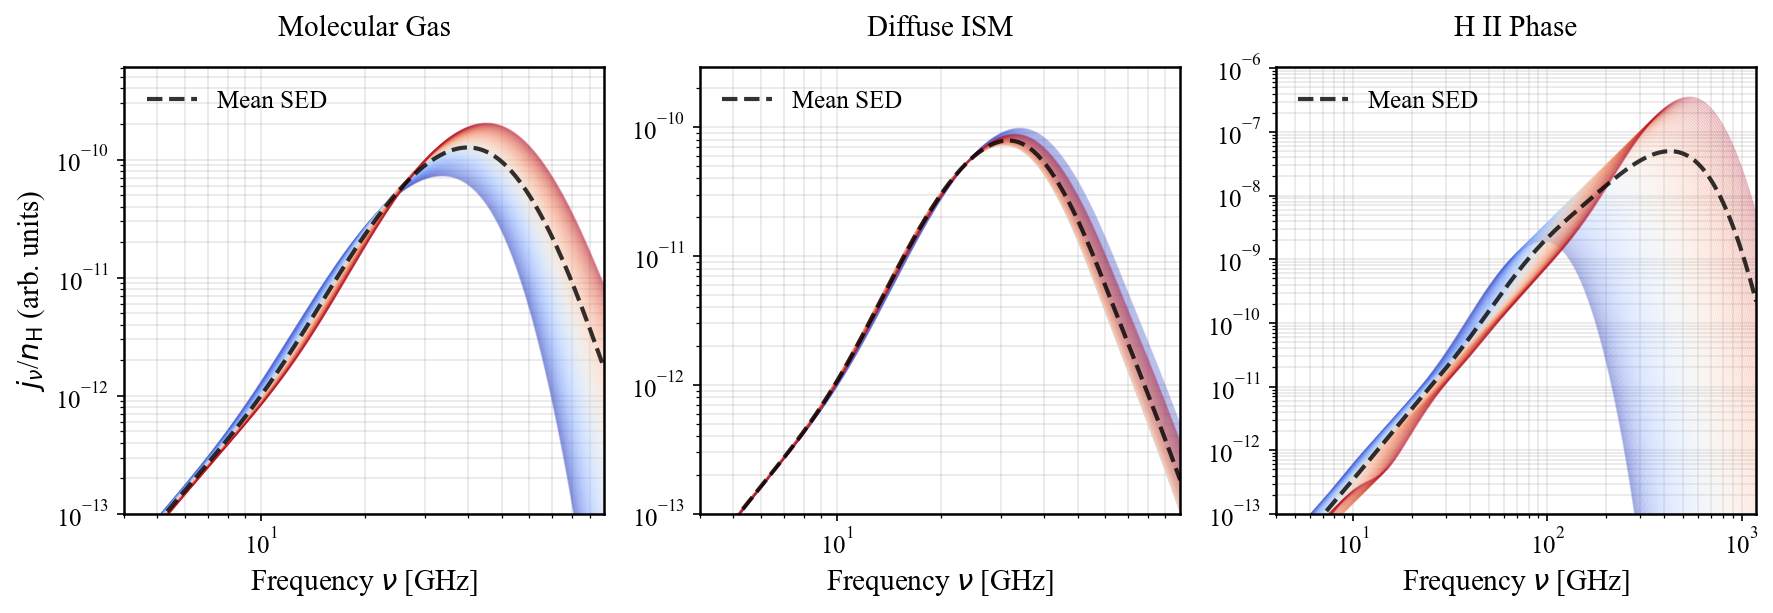

In [30]:
# Create multi-panel detailed figure with shared axes
fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                        # sharex='col', sharey='col'
                        )
axes = axes.flatten()

# Define panel data and labels
panels = [
    (freq_mole_a1, SED_a1_mole_envs, colors['c1'], 
     'Molecular Gas'),
    (freq_neum_a1, SED_a1_neum_envs, colors['c2'], 
     'Diffuse ISM'),
    (freq_ion_a1, SED_a1_ionm_envs, colors['c3'], 
     'H II Phase'),
    # (freq_mole_a2, SED_a2_mole_envs, colors['c4'], 
    #  'Molecular Gas ($a = 5.5 \,\\AA$ )'),
    # (freq_neum_a2, SED_a2_neum_envs, colors['c5'], 
    #  'Atomic Gas ($a = 5.5 \,\\AA$ )'),
    # (freq_ion_a2, SED_a2_ionm_envs, colors['c6'], 
    #  'Ionised Gas ($a = 5.5 \,\\AA$ )')
]

for i, (freqs, sed_data, color, title) in enumerate(panels):
    ax = axes[i]
    
    # Normalize all SEDs to peak = 1
    normalized_seds = []
    for j in range(len(sed_data)):
        if np.max(sed_data[j]) > 0:
            # sed_norm = sed_data[j] / np.max(sed_data[j])
            sed_norm = sed_data[j]
            normalized_seds.append(sed_norm)
    
    normalized_seds = np.array(normalized_seds)
    
    # Calculate statistics for shaded regions
    sed_clean = np.where(normalized_seds <= 0, np.nan, normalized_seds)
    mean_sed = np.nanmean(sed_clean, axis=0)
    # median_sed = np.nanmedian(sed_clean, axis=0)
    # p16_sed = np.nanpercentile(sed_clean, 16, axis=0)
    # p84_sed = np.nanpercentile(sed_clean, 84, axis=0)
    # p05_sed = np.nanpercentile(sed_clean, 5, axis=0)
    # p95_sed = np.nanpercentile(sed_clean, 95, axis=0)
    
    # # Plot shaded confidence regions
    # ax.fill_between(freq, p05_sed, p95_sed, 
    #                color=color, alpha=0.15, label='90% conf. interval')
    # ax.fill_between(freq, p16_sed, p84_sed, 
    #                color=color, alpha=0.3, label='68% conf. interval')
    
    n_seds = len(normalized_seds)
    cmap = cm.get_cmap('coolwarm')  # Or try 'plasma', 'coolwarm', 'tab10', etc.

    for j in range(n_seds):
        SED = normalized_seds[j]
        freq = freqs[j]
        # alpha_value = 0.1 + 0.4 * (j / n_seds)  # Alpha varies from 0.1 to 0.5
        # color = to_rgba(color, alpha=alpha_value)
        color_val = j / (n_seds - 1) if n_seds > 1 else 0
        color = cmap(color_val)
        ax.loglog(freq, SED, color=color, alpha=0.3, linewidth=0.8)
    
    # # Plot median line
    # ax.loglog(freq, median_sed, color=color, linewidth=3, 
    #          label='Median SED')
    
    # Plot mean line
    ax.loglog(freq, mean_sed, color='black', linewidth=2, 
             label='Mean SED', linestyle='--', alpha=0.8)
    
    # Formatting
    ax.set_title(title, fontsize=14, pad=15)
    ax.grid(True, alpha=0.3, which='both')
    
    # Labels only for bottom and left panels (shared axes handle the rest)
    # if i >= 3:  # Bottom row
    ax.set_xlabel(r'Frequency $\nu$ [GHz]', fontsize=14)
    if i % 3 == 0:  # Left column
        ax.set_ylabel(r'$j_\nu$/$n_{\rm H}$ (arb. units)', fontsize=14)
    
    # Set consistent axis limits: 3 orders of magnitude
    ax.set_xlim(4, freq[-1])
    ymax = 3. * normalized_seds.max()
    ax.set_ylim(1e-13, ymax)  # Three orders of magnitude with peak at 1
    # ax.set_xlim(1e9, 5e11)
    # ax.set_ylim(1e-40, 6e-35)
    
    # Add legend to all panels with compact formatting
    ax.legend(loc='upper left', fontsize=12, frameon=False, 
             fancybox=True, shadow=True, framealpha=0.9,
            #  bbox_to_anchor=(0.98, 0.98)
             )

# Add overall title
# fig.suptitle('Normalized Detailed SED Comparison: Environment and Grain Size Effects', 
#              fontsize=18, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('SED_multipanel_env.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
WIM_params = {'nh' : 0.1, 'T': 8000., 'Chi': 1., 'xh': 0.99, 'xC': 1e-3, 'y' : 0, 'gamma': 0, 'dipole': 9.3}
MC_params = {'nh' : 3e2, 'T': 20., 'Chi': 1e-2, 'xh': 0., 'xC': 1e-4, 'y' : 0.99,  'gamma': 0, 'dipole': 9.3}    
CNM_params = {'nh' : 30, 'T': 100., 'Chi': 1, 'xh': 1.2e-3, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}
DC_params = {'nh' : 1e4, 'T': 10., 'Chi': 1e-4, 'xh': 0., 'xC': 1e-6, 'y' : 0.999,  'gamma': 0, 'dipole': 9.3, 'line':7}
Hii_params = {'nh' : 1e4, 'T': 1e4, 'Chi': 1e4, 'xh': 0.999, 'xC': 1e-4, 'y' : 0,  'gamma': 0, 'dipole': 9.3, 'line':7}



def beta_val(a, d):
    if a<=a2:
        beta=Grain.cylindrical_params(a, d)[1]
    else:
        beta=0.
    return beta


a_tab = makelogtab(a_min, a_max, 100)

MC_sed_disk = []
DC_sed_disk = []
CNM_sed_disk = []
WIM_sed_disk = []
Hii_sed_disk = []

# MC_sed_sphere = []
# DC_sed_sphere = []
# CNM_sed_sphere = []
# WIM_sed_sphere = []

for a in a_tab:
    beta = beta_val(a, d)

    frequency, WIM_sed = SpyDust_given_grain_size_shape(WIM_params, a, beta, 
                                            min_freq=0.1, max_freq=100.0, n_freq=200,
                                            N_angular_Omega=500,
                                            a2=a2)
    frequency, DC_sed = SpyDust_given_grain_size_shape(DC_params, a, beta, 
                                            min_freq=0.1, max_freq=100.0, n_freq=200,
                                            N_angular_Omega=500,
                                            a2=a2)
    frequency, CNM_sed = SpyDust_given_grain_size_shape(CNM_params, a, beta, 
                                            min_freq=0.1, max_freq=100.0, n_freq=200,
                                            N_angular_Omega=500,
                                            a2=a2)
    frequency, MC_sed = SpyDust_given_grain_size_shape(MC_params, a, beta, 
                                            min_freq=0.1, max_freq=100.0, n_freq=200,
                                            N_angular_Omega=500,
                                            a2=a2)
    frequency_Hii, Hii_sed = SpyDust_given_grain_size_shape(Hii_params, a, beta, 
                                            min_freq=1, max_freq=1000.0, n_freq=200,
                                            N_angular_Omega=500,
                                            a2=a2)
    MC_sed_disk.append(MC_sed)
    WIM_sed_disk.append(WIM_sed)
    DC_sed_disk.append(DC_sed)
    CNM_sed_disk.append(CNM_sed)
    Hii_sed_disk.append(Hii_sed)

    # frequency, WIM_sed_sph = SpyDust_given_grain_size_shape(WIM_params, a, beta,
    #                                         min_freq=0.1, max_freq=100.0, n_freq=200,
    #                                         N_angular_Omega=500,
    #                                         a2=a_min)
    # frequency, DC_sed_sph = SpyDust_given_grain_size_shape(DC_params, a, beta,
    #                                         min_freq=0.1, max_freq=100.0, n_freq=200,
    #                                         N_angular_Omega=500,
    #                                         a2=a_min)
    # frequency, CNM_sed_sph = SpyDust_given_grain_size_shape(CNM_params, a, beta,
    #                                         min_freq=0.1, max_freq=100.0, n_freq=200,
    #                                         N_angular_Omega=500,
    #                                         a2=a_min)
    # frequency, MC_sed_sph = SpyDust_given_grain_size_shape(MC_params, a, beta,
    #                                         min_freq=0.1, max_freq=100.0, n_freq=200,
    #                                         N_angular_Omega=500,
    #                                         a2=a_min)
    # MC_sed_sphere.append(MC_sed_sph)
    # WIM_sed_sphere.append(WIM_sed_sph)
    # DC_sed_sphere.append(DC_sed_sph)
    # CNM_sed_sphere.append(CNM_sed_sph)

MC_sed_disk = np.array(MC_sed_disk)
WIM_sed_disk = np.array(WIM_sed_disk)
DC_sed_disk = np.array(DC_sed_disk)
CNM_sed_disk = np.array(CNM_sed_disk)
Hii_sed_disk = np.array(Hii_sed_disk)
# MC_sed_sphere = np.array(MC_sed_sphere)
# WIM_sed_sphere = np.array(WIM_sed_sphere)
# DC_sed_sphere = np.array(DC_sed_sphere)
# CNM_sed_sphere = np.array(CNM_sed_sphere)

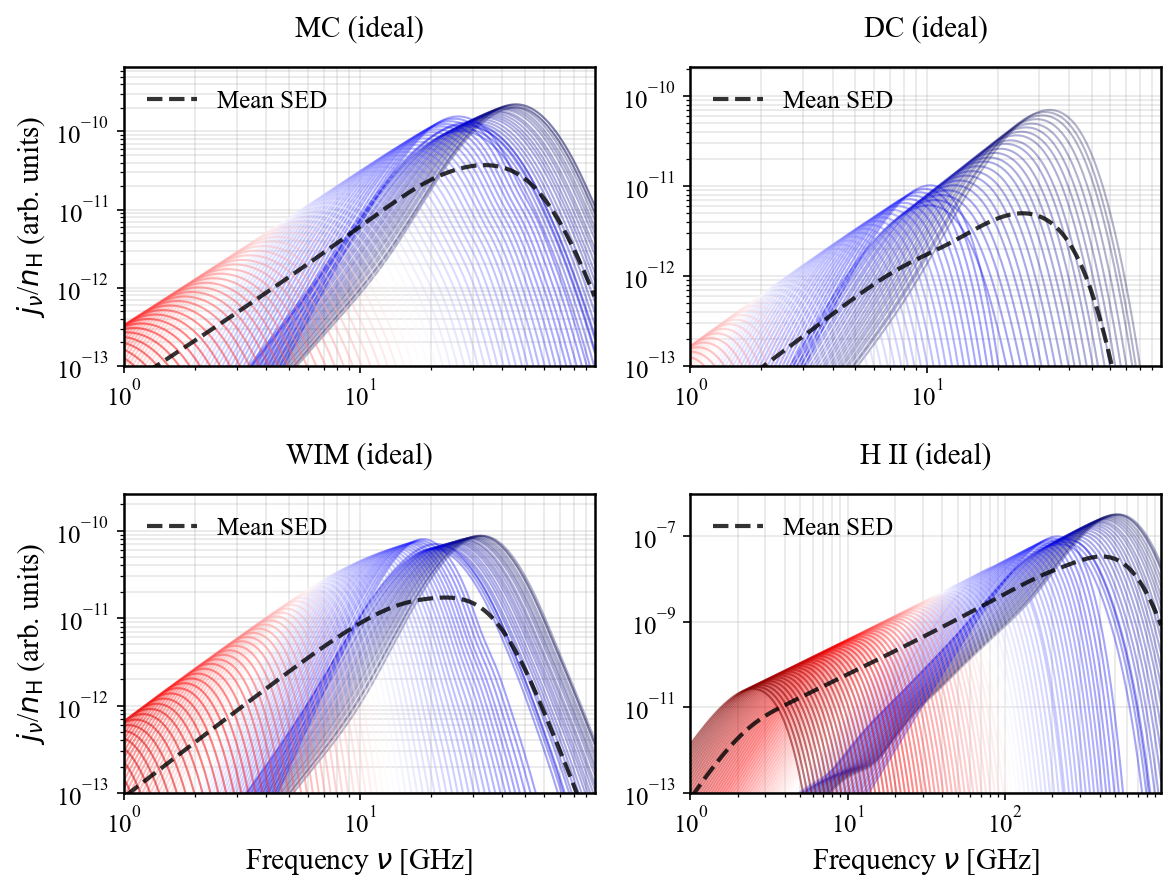

In [32]:

# Create multi-panel detailed figure with shared axes
fig, axes = plt.subplots(2, 2, figsize=(8, 6), 
                        # sharex='col', sharey='row'
                        )
axes = axes.flatten()

# Define panel data and labels
panels = [
    (MC_sed_disk, colors['c1'], 
     'MC (ideal)'),
    (DC_sed_disk, colors['c2'], 
     'DC (ideal)'),
    (WIM_sed_disk, colors['c3'], 
     'WIM (ideal)'),
    (Hii_sed_disk, colors['c4'], 
     'H II (ideal)')
]

for i, (sed_data, color, title) in enumerate(panels):
    ax = axes[i]

    if i < 3:
        freq=frequency
    else:
        freq=frequency_Hii
    
    # Normalize all SEDs to peak = 1
    normalized_seds = []
    for j in range(len(sed_data)):
        if np.max(sed_data[j]) > 0:
            # sed_norm = sed_data[j] / np.max(sed_data[j])
            sed_norm = sed_data[j]
            normalized_seds.append(sed_norm)
    
    normalized_seds = np.array(normalized_seds)
    
    # Calculate statistics for shaded regions
    sed_clean = np.where(normalized_seds <= 0, np.nan, normalized_seds)
    mean_sed = np.nanmean(sed_clean, axis=0)
    # median_sed = np.nanmedian(sed_clean, axis=0)
    # p16_sed = np.nanpercentile(sed_clean, 16, axis=0)
    # p84_sed = np.nanpercentile(sed_clean, 84, axis=0)
    # p05_sed = np.nanpercentile(sed_clean, 5, axis=0)
    # p95_sed = np.nanpercentile(sed_clean, 95, axis=0)
    
    # # Plot shaded confidence regions
    # ax.fill_between(freq, p05_sed, p95_sed, 
    #                color=color, alpha=0.15, label='90% conf. interval')
    # ax.fill_between(freq, p16_sed, p84_sed, 
    #                color=color, alpha=0.3, label='68% conf. interval')
    
    # Plot individual SEDs with varying colors
    # n_seds = len(normalized_seds)
    # for j, SED in enumerate(normalized_seds):
    #     # Create a color gradient from light to dark version of the base color
    #     alpha_value = 0.1 + 0.4 * (j / n_seds)  # Alpha varies from 0.1 to 0.5
    #     varying_color = to_rgba(color, alpha=alpha_value)
    #     ax.loglog(freq, SED, color=varying_color, linewidth=0.8)

    # Plot individual SEDs with colormap variation
    n_seds = len(normalized_seds)
    cmap = cm.get_cmap('seismic')  # Or try 'plasma', 'coolwarm', 'tab10', etc.

    for j, SED in enumerate(normalized_seds):
        # Use colormap to vary colors across the spectrum
        color_val = j / (n_seds - 1) if n_seds > 1 else 0
        line_color = cmap(color_val)
        alpha_val = j / (4*n_seds) + 0.3
        ax.loglog(freq, SED, color=line_color, alpha=alpha_val, linewidth=1)
        # ax.loglog(freq, SED, color=color, alpha=0.2, linewidth=0.8)
    
    # # Plot median line
    # ax.loglog(freq, median_sed, color=color, linewidth=3, 
    #          label='Median SED')
    
    # Plot mean line
    ax.loglog(freq, mean_sed, color='black', linewidth=2, 
             label='Mean SED', linestyle='--', alpha=0.8)
    
    # Formatting
    ax.set_title(title, fontsize=14, pad=15)
    ax.grid(True, alpha=0.3, which='both')
    
    # Labels only for bottom and left panels (shared axes handle the rest)
    if i >= 2:  # Bottom row
        ax.set_xlabel(r'Frequency $\nu$ [GHz]', fontsize=14)
    if i % 2 == 0:  # Left column
        ax.set_ylabel(r'$j_\nu$/$n_{\rm H}$ (arb. units)', fontsize=14)
    
    # Set consistent axis limits: 3 orders of magnitude
    # ax.set_xlim(freq[0], freq[-1])
    # ax.set_ylim(1e-13, 6e-10)  # Three orders of magnitude with peak at 1

    # Set consistent axis limits: 3 orders of magnitude
    ax.set_xlim(1, freq[-1])
    ymax = 3. * normalized_seds.max()
    ax.set_ylim(1e-13, ymax)  # Three orders of magnitude with peak at 1
    
    # Add legend to all panels with compact formatting
    ax.legend(loc='upper left', fontsize=12, frameon=False, 
             fancybox=True, shadow=True, framealpha=0.9,
            #  bbox_to_anchor=(0.98, 0.98)
             )

# Add overall title
# fig.suptitle('Normalized Detailed SED Comparison: Environment and Grain Size Effects', 
#              fontsize=18, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('SED_multipanel_size.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Alternative approach: Use colormap for more dramatic color variation
"""
# Replace the individual SED plotting section above with this for colormap variation:

import matplotlib.cm as cm

# Plot individual SEDs with colormap variation
n_seds = len(normalized_seds)
cmap = cm.get_cmap('viridis')  # Or try 'plasma', 'coolwarm', 'tab10', etc.

for j, SED in enumerate(normalized_seds):
    # Use colormap to vary colors across the spectrum
    color_val = j / (n_seds - 1) if n_seds > 1 else 0
    line_color = cmap(color_val)
    ax.loglog(freq, SED, color=line_color, alpha=0.6, linewidth=0.8)
"""

## Publication Figure 4: Peak Frequency Analysis

This figure analyzes the peak frequencies and peak emissivities across the different scenarios.

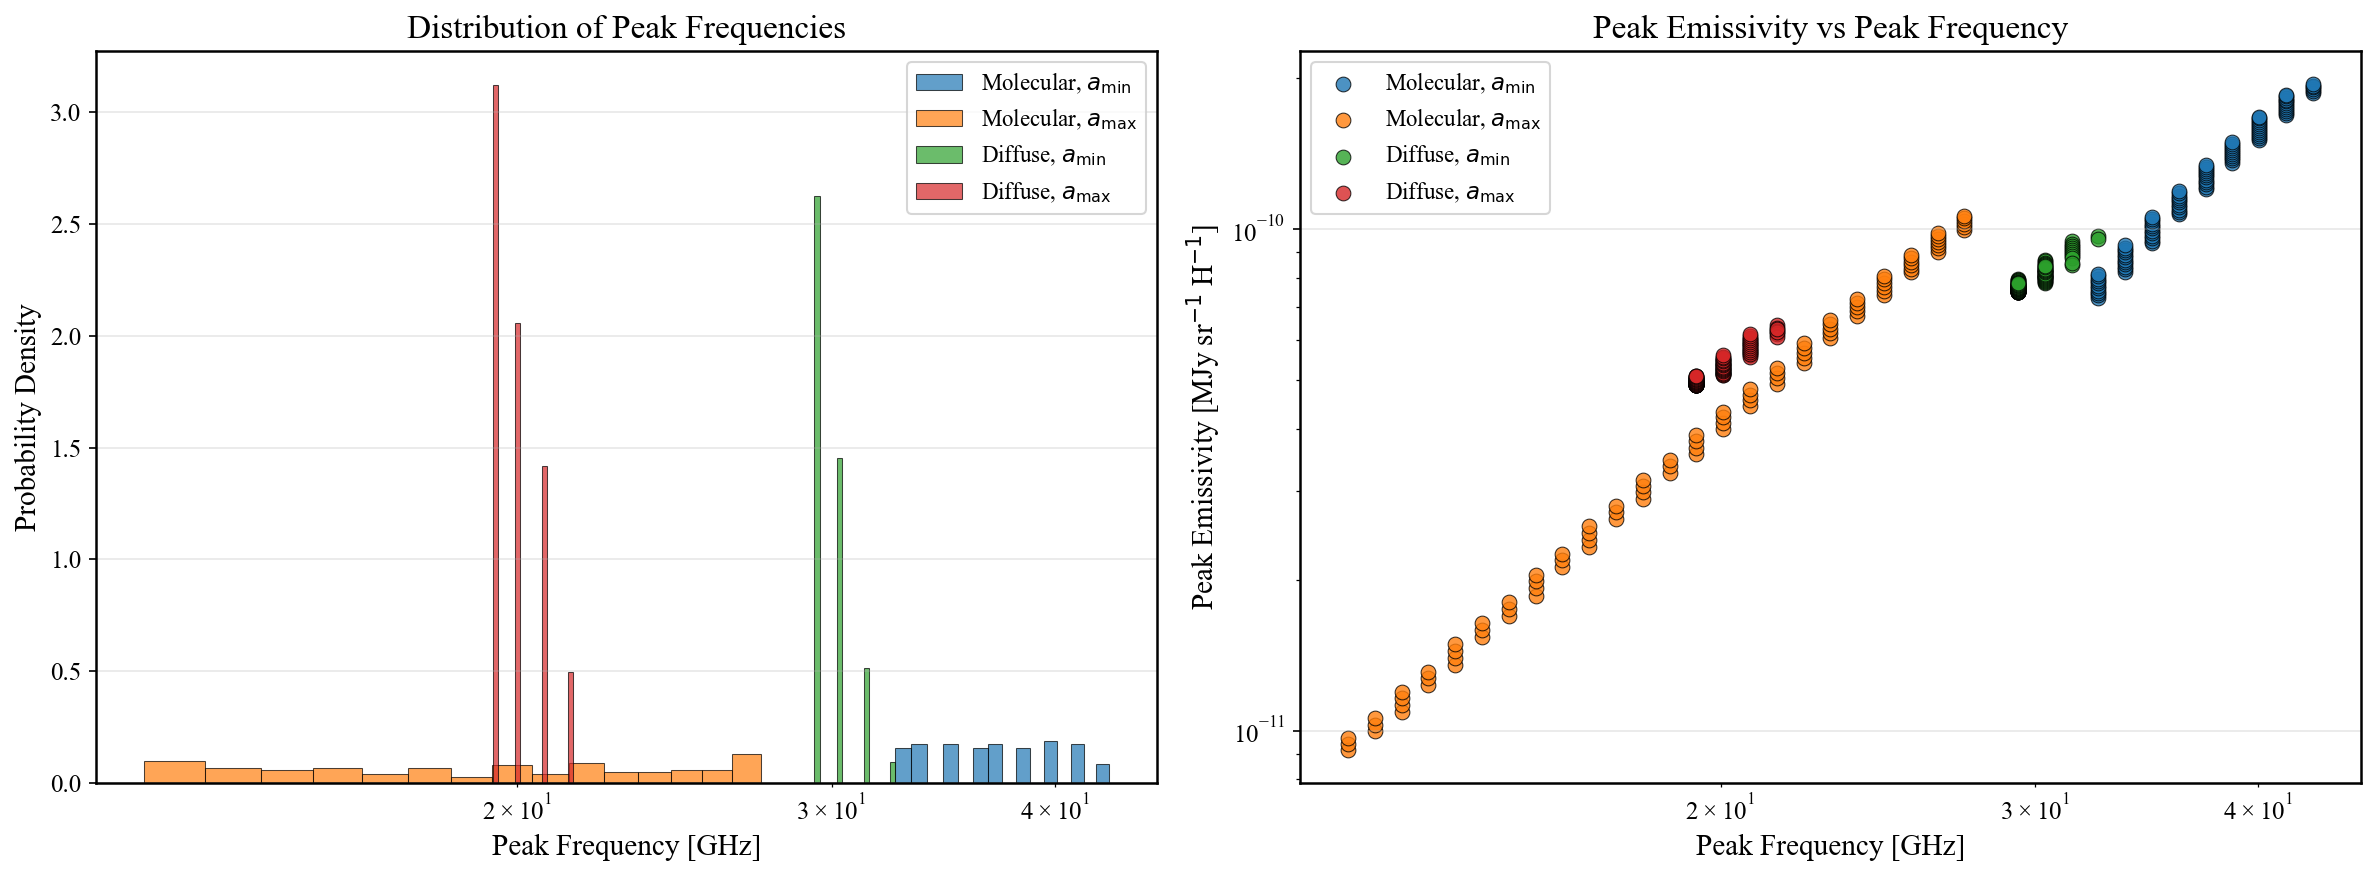


=== Peak Frequency Statistics ===
Molecular, $a_{\mathrm{min}}$:
  Mean: 37.27 ± 3.17 GHz
  Median: 37.37 GHz
  Range: 32.55 - 42.90 GHz

Molecular, $a_{\mathrm{max}}$:
  Mean: 20.00 ± 4.69 GHz
  Median: 20.07 GHz
  Range: 12.37 - 27.38 GHz

Diffuse, $a_{\mathrm{min}}$:
  Mean: 29.96 ± 0.80 GHz
  Median: 29.34 GHz
  Range: 29.34 - 32.55 GHz

Diffuse, $a_{\mathrm{max}}$:
  Mean: 20.01 ± 0.67 GHz
  Median: 20.07 GHz
  Range: 19.39 - 21.50 GHz



In [65]:
def find_sed_peaks(freq_array, sed_array):
    """Find peak frequency and peak emissivity for each SED"""
    peaks_freq = []
    peaks_emiss = []
    
    for sed in sed_array:
        # Find peak (maximum emissivity)
        peak_idx = np.nanargmax(sed)
        peak_freq = freq_array[peak_idx]
        peak_emiss = sed[peak_idx]
        
        peaks_freq.append(peak_freq)
        peaks_emiss.append(peak_emiss)
    
    return np.array(peaks_freq), np.array(peaks_emiss)

# Calculate peak properties for each scenario
peak_data = {}
scenarios_data = {
    'Molecular, $a_{\\mathrm{min}}$': (SED_amin_mole_envs, colors['mole_amin']),
    'Molecular, $a_{\\mathrm{max}}$': (SED_amax_mole_envs, colors['mole_amax']),
    'Diffuse, $a_{\\mathrm{min}}$': (SED_amin_diffuse_envs, colors['diffuse_amin']),
    'Diffuse, $a_{\\mathrm{max}}$': (SED_amax_diffuse_envs, colors['diffuse_amax'])
}

for label, (sed_data, color) in scenarios_data.items():
    peak_freq, peak_emiss = find_sed_peaks(freq, sed_data)
    peak_data[label] = {'freq': peak_freq, 'emiss': peak_emiss, 'color': color}

# Create peak analysis figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Peak frequency distribution
for label, data in peak_data.items():
    ax1.hist(data['freq'], bins=15, alpha=0.7, color=data['color'], 
            label=label, density=True, edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Peak Frequency [GHz]', fontsize=14)
ax1.set_ylabel('Probability Density', fontsize=14)
ax1.set_title('Distribution of Peak Frequencies', fontsize=16)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Panel 2: Peak emissivity vs peak frequency
for label, data in peak_data.items():
    ax2.scatter(data['freq'], data['emiss'], color=data['color'], 
               label=label, alpha=0.8, s=50, edgecolors='black', linewidth=0.5)

ax2.set_xlabel('Peak Frequency [GHz]', fontsize=14)
ax2.set_ylabel('Peak Emissivity [MJy sr$^{-1}$ H$^{-1}$]', fontsize=14)
ax2.set_title('Peak Emissivity vs Peak Frequency', fontsize=16)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('SED_peak_analysis_publication.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Peak Frequency Statistics ===")
for label, data in peak_data.items():
    mean_freq = np.mean(data['freq'])
    std_freq = np.std(data['freq'])
    median_freq = np.median(data['freq'])
    print(f"{label}:")
    print(f"  Mean: {mean_freq:.2f} ± {std_freq:.2f} GHz")
    print(f"  Median: {median_freq:.2f} GHz")
    print(f"  Range: {np.min(data['freq']):.2f} - {np.max(data['freq']):.2f} GHz")
    print()